# Quantum Maze Solver

In [ ]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.circuit.library import GroverOperator
from maze_oracle import MazeOracleGenerator

In [72]:
Edge = tuple[int, int]

class Path(list[Edge]):
    def __repr__(self):
        if len(self) > 0:
            s = [repr(e) for e in self]
            return str.join(' -> ', s)
        else:
            return '()'

class Maze:
    def __init__(self, num_nodes: int, edges: list[Edge], directed: bool = False):
        self.num_nodes = num_nodes
        self.edges = edges
        self.directed = directed
        self.max_path_length = num_nodes - 1

class QuantumMazeCircuit(Maze, QuantumCircuit):
    def __init__(self, from_maze: Maze):
        self.node_bits_size = int(np.ceil( np.log2(from_maze.num_nodes) ))
        self.num_qubit_in_path = (from_maze.max_path_length + 1) * self.node_bits_size
        self.total_size = self.num_qubit_in_path + from_maze.max_path_length

        Maze.__init__(self, from_maze.num_nodes, from_maze.edges, from_maze.directed)
        QuantumCircuit.__init__(self, self.total_size, self.num_qubit_in_path)

class QuantumMazeSolver:
    def generate_circuit(self, maze: Maze) -> QuantumMazeCircuit:
        ### Setup
        circ = QuantumMazeCircuit(maze)
        circ.name = 'Maze Solver'
        # Get oracle
        oracle = MazeOracleGenerator(circ.num_nodes, circ.max_path_length, circ.directed).add_edges(circ.edges).generate()
        # Get grover's diffuser
        diffuser = GroverOperator(QuantumCircuit(circ.num_qubit_in_path))
        # Compute repetition time
        iterations = int(np.ceil( (np.pi / 4) * np.sqrt(circ.num_qubit_in_path) ))

        ### Build
        # Make superpositions
        for i in range(circ.num_qubit_in_path):
            circ.h(i)
        # Repeat grover operation
        for i in range(iterations):
            circ.barrier()
            circ.append(oracle, range(circ.total_size))             # Apply oracle
            circ.append(diffuser, range(circ.num_qubit_in_path))    # Apply diffuser

        return circ

    def __result_to_path(self, result: str, path_length: int, node_size: int) -> Path:
        path = []
        for i in range(path_length):
            offset = i*node_size
            n2 = int(result[offset : offset+node_size], 2)
            n1 = int(result[offset+node_size : offset+ 2*node_size], 2)
            path.insert(0, (n1, n2))
        return Path(path)

    def run(self, circuit: QuantumMazeCircuit, shots: int = 1) -> list[Path]:
        sim = AerSimulator()
        transpiled = transpile(circuit, sim)
        # Add measure to circuit
        transpiled.measure(range(circuit.num_qubit_in_path), range(circuit.num_qubit_in_path))
        # Run
        results = sim.run(transpiled, shots=shots, memory=True).result().get_memory()
        paths = [self.__result_to_path(r, circuit.max_path_length, circuit.node_bits_size) for r in results]
        return paths

    def solve(self, maze: Maze) -> Path:
        maze_circ = self.generate_circuit(maze)
        path = self.run(maze_circ, shots=1)
        return path[0]

### Tests

In [66]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
    (3, 3) # self-cycle, for termination
]
maze = Maze(4, edges, directed=True)
solver = QuantumMazeSolver()

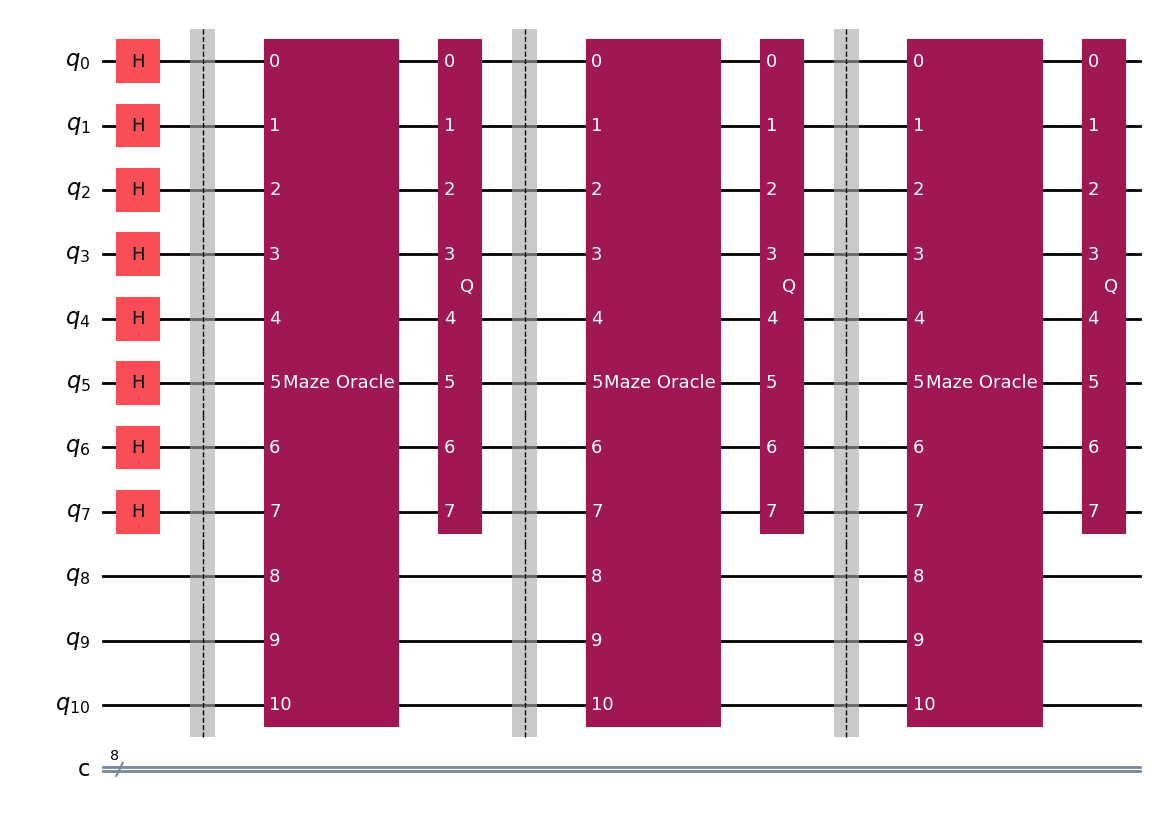

In [56]:
qc = solver.generate_circuit(maze)
qc.draw('mpl')

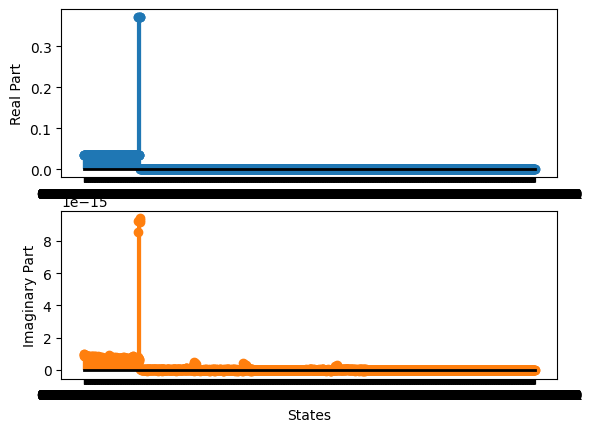

In [41]:
import os
import sys
sys.path.insert(0, os.path.abspath('utils'))
from qiskit.quantum_info import Statevector
sys.path.insert(1, '../')
from utils import Helpers as hp


s = Statevector.from_label('00000000000')
hp.plot_statevector(s.evolve(qc), '')

In [73]:
result = solver.solve(maze)
print(result)

(0, 1) -> (1, 3) -> (3, 3)
